# Markovian Model for steady-state throughput CUBIC and Hybla
This notebook is based on the model presented in the paper by Bao Wong and Leung. First we implement the model for CUBIC as presented in the paper (we call it the timeBased model, since the loss model is that the inter-packet loss time is assumed eponential). Then we adapt the model to work with Hybla.

Note: Along the way, we noticed that the model is not very realistic as it assumes a time based error model. However, errors are dependent on the number of packets sent. This is why we propose a new model (that we call the packetBased model). It can be found in the packetBasedMarkovianModel.ipynb file.

## Implementing the model for CUBIC

First we start with an introductory example showing the transition probabilities of different states.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/jeanmegret/opt/anaconda3/envs/qpepcca/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:939: LinAlgWarning: Diagonal number 100 is exactly zero. Singular matrix.
  self.M_lu = lu_factor(M)


Could not compute eigenvalues. Setting pi to 0
Average throughput is 0.5104681498063091


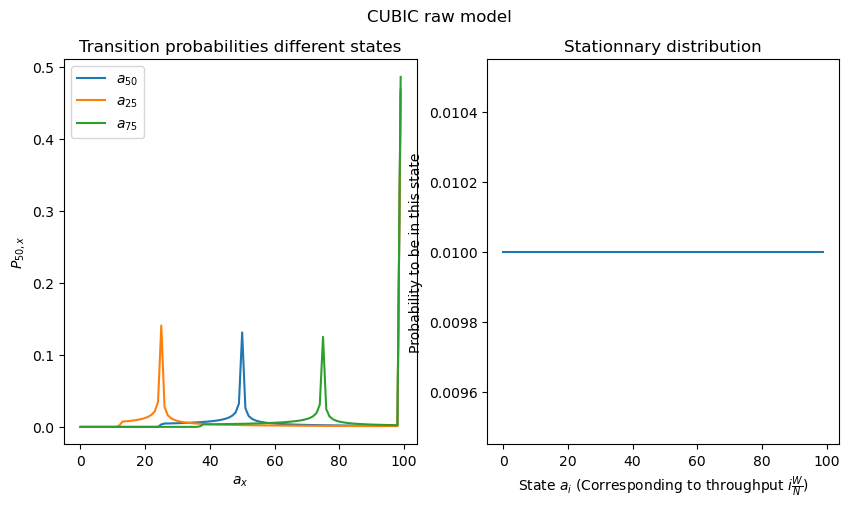

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ccaModels import CCA_MarkovChain_CUBIC_time

#plt.rcParams['text.usetex'] = True
#plt.rcParams.update(plt.rcParamsDefault)

wired = CCA_MarkovChain_CUBIC_time(err_rate=0.5,beta=0.5,alpha=1,N=100,C =50)
wired.avg_throughput()
print(f"Average throughput is {wired.ssThroughput}")

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(np.arange(wired.N),wired.P[50,:],label = "$a_{50}$")
axs[0].plot(np.arange(wired.N),wired.P[25,:],label = "$a_{25}$")
axs[0].plot(np.arange(wired.N),wired.P[75,:],label = "$a_{75}$")
axs[0].set_title(r"Transition probabilities different states")
axs[0].set_ylabel(r"$P_{50,x}$")
axs[0].set_xlabel(r"$a_x$")
axs[0].legend()
axs[1].plot(np.arange(wired.N),wired.pi)
axs[1].set_title(r"Stationnary distribution")
axs[1].set_xlabel(r"State $a_i$ (Corresponding to throughput $i\frac{W}{N}$)")
axs[1].set_ylabel(r'Probability to be in this state')
fig.suptitle("CUBIC raw model")
plt.show()

Now we try to reproduce the different figures form the original paper.

Could not compute eigenvalues. Setting pi to 0
Could not compute eigenvalues. Setting pi to 0
Could not compute eigenvalues. Setting pi to 0
Could not compute eigenvalues. Setting pi to 0
Could not compute eigenvalues. Setting pi to 0


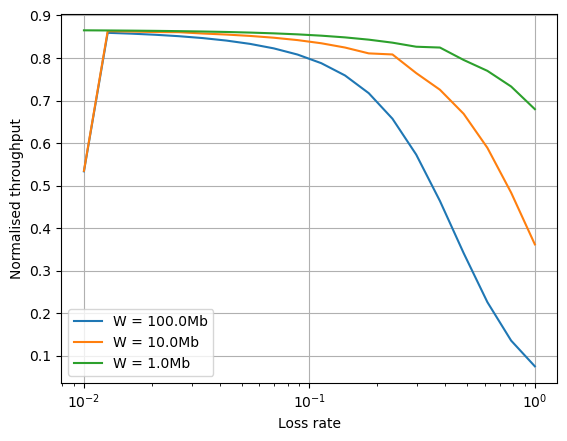

In [7]:
# Reproducing Fig. 5 (changing the RTT)
link = CCA_MarkovChain_CUBIC_time(beta = 0.5, alpha=1,N=50,C=100)
loss_rates = np.logspace(-2,0,20)
rtts = [0.1,0.01,0.001]
throughputs = np.zeros((len(loss_rates),len(rtts)))
for j,rtt in enumerate(rtts):
    link.RTT_real = rtt
    link.update()
    for i,l in enumerate(loss_rates):
        link.err_rate = l
        link.avg_throughput()
        throughputs[i,j] = link.ssThroughput

# Now plot the throughput as a function of the loss rate with series representing the RTT
fig, ax = plt.subplots()
for j,rtt in enumerate(rtts):
    ax.plot(loss_rates,throughputs[:,j],label = f"W = {1000*rtt}Mb")
ax.set_xscale('log')
ax.set_xlabel("Loss rate")
ax.set_ylabel("Normalised throughput")
ax.legend()
plt.grid()
plt.show()

Text(0, 0.5, 'Normalised throughput')

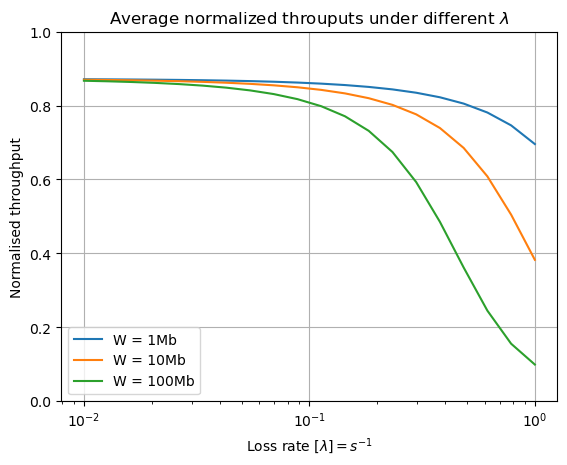

In [3]:
# Fig 5. from paper (Changing C, the bandwidth)
err_rates = np.logspace(-2,0,20)
throughputs = np.zeros([3,len(err_rates)])
for k,C in enumerate([10,100,1000]):
    for i, l in enumerate(err_rates):
        wired = CCA_MarkovChain_CUBIC_time(err_rate=l,beta=0.5,alpha=1,N=100,C = C ,RTT_real=0.1)
        throughputs[k,i] = wired.avg_throughput()

plt.plot(err_rates,throughputs[0,:], label = "W = 1Mb")
plt.plot(err_rates,throughputs[1,:], label = "W = 10Mb")
plt.plot(err_rates,throughputs[2,:], label = "W = 100Mb")
plt.semilogx()
plt.legend()
plt.ylim([0,1])
plt.grid()
plt.title(r"Average normalized throuputs under different $\lambda$")
plt.xlabel(r"Loss rate $[\lambda] = s^{-1}$")
plt.ylabel(r'Normalised throughput')

Text(0, 0.5, 'Normalised throughput')

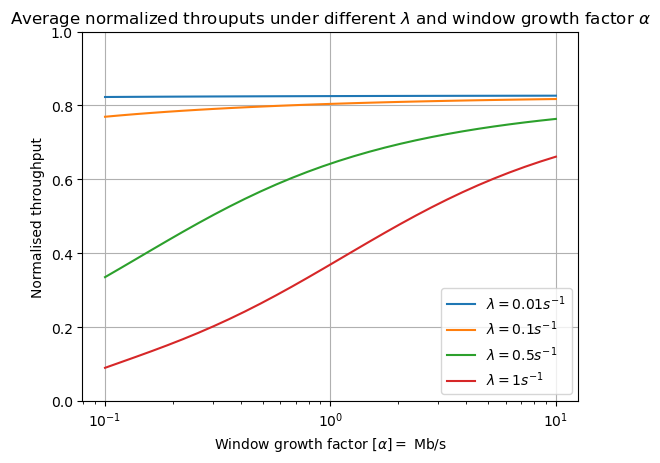

In [7]:
# Fig. 6
alphas = np.logspace(-1,1,30)
throughputs = np.zeros([4,len(alphas)])
for k,lam in enumerate([0.01,0.1,0.5,1]):
    for i, alpha in enumerate(alphas):
        wired = CCA_MarkovChain_CUBIC_time(err_rate=lam,beta=0.5,alpha=alpha,N=100,C=100,RTT_real=0.1)
        throughputs[k,i] = wired.avg_throughput()

plt.plot(alphas,throughputs[0,:], label = r"$\lambda = 0.01 s^{-1}$")
plt.plot(alphas,throughputs[1,:], label = r"$\lambda = 0.1 s^{-1}$")
plt.plot(alphas,throughputs[2,:], label = r"$\lambda = 0.5 s^{-1}$")
plt.plot(alphas,throughputs[3,:], label = r"$\lambda = 1 s^{-1}$")
plt.semilogx()
plt.legend()
plt.ylim([0,1])
plt.grid()
plt.title(r"Average normalized throuputs under different $\lambda$ and window growth factor $\alpha$")
plt.xlabel(r"Window growth factor $[\alpha] =$ Mb/s")
plt.ylabel(r'Normalised throughput')

Text(0, 0.5, 'Normalised throughput')

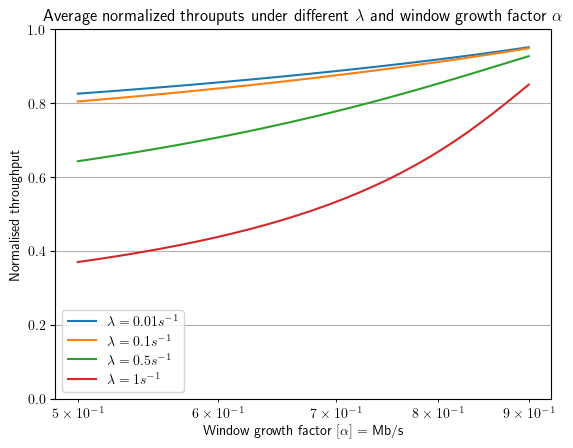

In [11]:
# same as before but with beta instead of alpha
betas = np.linspace(0.5,0.9,30)
throughputs = np.zeros([4,len(betas)])
for k,lam in enumerate([0.01,0.1,0.5,1]):
    for i, beta in enumerate(betas):
        wired = CCA_MarkovChain_CUBIC_time(err_rate=lam,beta=beta,alpha=1,N=100,C=100,RTT_real=0.1)
        throughputs[k,i] = wired.avg_throughput()

plt.plot(betas,throughputs[0,:], label = r"$\lambda = 0.01 s^{-1}$")
plt.plot(betas,throughputs[1,:], label = r"$\lambda = 0.1 s^{-1}$")
plt.plot(betas,throughputs[2,:], label = r"$\lambda = 0.5 s^{-1}$")
plt.plot(betas,throughputs[3,:], label = r"$\lambda = 1 s^{-1}$")
plt.legend()
plt.ylim([0,1])
plt.grid()
plt.title(r"Average normalized throuputs under different $\lambda$ and window growth factor $\alpha$")
plt.xlabel(r"Window growth factor $[\alpha] =$ Mb/s")
plt.ylabel(r'Normalised throughput')

### Simulating the markov process

Instead of computing the solution, we simulate the markov process and take the mean value from it. Finally we compare with the model.

1 12.499666077034544
4160 161.18831311230096
1 13.277974992120999
1 11.745103397315614
90 45.18785855489721
326 70.26179920551436
212 60.992820900352086
6 20.383188339041645
590 84.46786764400447
0 7.8228153518154375
0 1.4806525610277175
7 19.792185149146412
87 45.046455177010074
721 91.08223544715163
456 78.28515498291975
0 0.053413783075592594
2892 142.73249308364976
338 70.95511038085579
7 20.915491850424775
0 1.150958809105301
76 42.62126169599291
312 69.16323573493392
65 41.62785274570987
2 14.518793849702563
42 35.43208895662489
22 29.460508776365586
136 52.3684939816488
171 56.82380035798643
2 14.104662336665053
229 61.60836459981019
282 66.8733931312477
25 30.845262994201377
5682 179.36511578140494
22 29.705909807851732
24 29.932903935881285
2 13.673662581057075
17 26.32070708566811
0 7.638259672057071
0 6.287175247863934
1390 111.85385359265942
2283 132.97259372394836
0 0.854202954880061
5036 171.65574457203908
1 12.483620762366153
4653 167.3136745411313
21 29.24116936607419
3

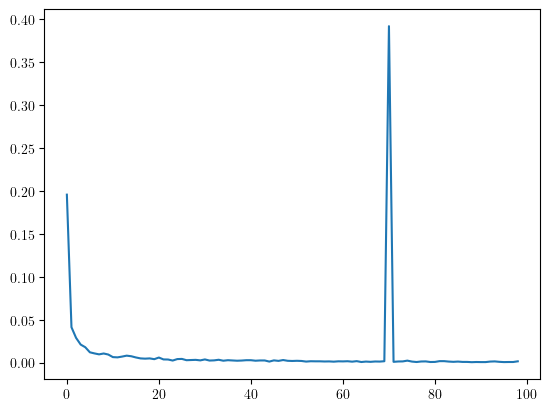

In [83]:
time_steps = 10000
l = 50 # average time between two events.
beta = 0.7
RTT = 0.1
C = 1000
N = 100
alpha = 4
W = C/RTT

segment = CCA_MarkovChain_CUBIC_time(err_rate=l,beta=beta,alpha=alpha,N=N,C=C,RTT_real=RTT)
states = np.zeros(time_steps)
initial_state = 2

time_until_loss = np.random.exponential(l,time_steps)

def wn_cub(x,t):
    return alpha*(t-np.cbrt(x*(1-beta)/alpha))**3+x

for t in range(time_steps):
    if t == 0:
        states[t] = initial_state
        continue
    candidate_next_value = wn_cub(segment.a[int(states[t-1])],time_until_loss[t])
    print(int(candidate_next_value/W), time_until_loss[t])
    if candidate_next_value/W>N:
        # Congestion
        states[t] = int(N*beta)
    else:
        states[t] = int(candidate_next_value/W)

# plt.plot(states)
# plt.title('CUBIC Markov Chain simulation')
# plt.xlabel('Time (rtt unit)')
# plt.ylabel('Congestion window size (packets)')
# plt.ylim(0,max(states))
# # for i in segment.a:
# #     plt.axhline(i)
# plt.show()
print("Average of the congestion window size in packets "+ str(np.average(states)))
print("Average throughput in packets per second "+ str(np.average(states)/RTT ))
plt.plot(np.histogram(states, bins=np.arange(N), density=True)[0])
plt.show()

## Adapting the model to Hybla

Now we adapt the model to Hybla, the main difference is in the growth time (since it is another growth function).

Average normalised throughput is 0.040000520770802794


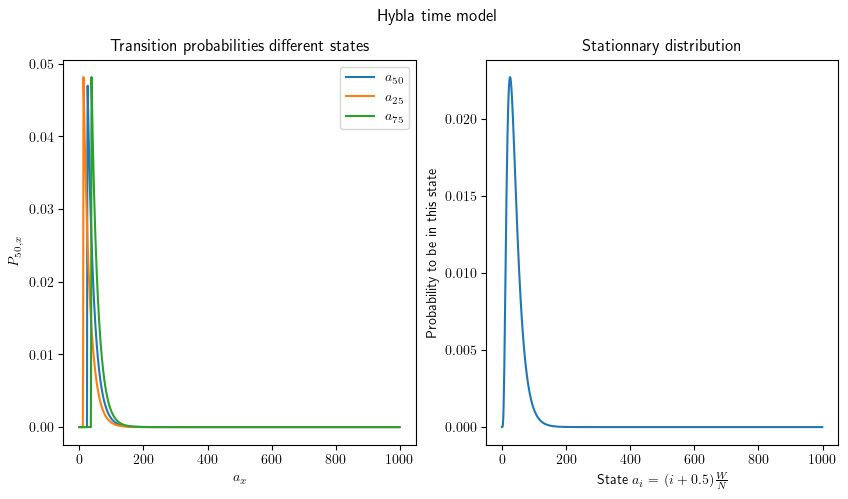

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from ccaModels import CCA_MarkovChain_Hybla_time

wired = CCA_MarkovChain_Hybla_time(err_rate=20,beta=0.5,N=1000,C =1000, RTT0=0.05, RTT_real=0.5)
wired.avg_throughput()
print(f"Average normalised throughput is {wired.ssThroughput}")

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(np.arange(wired.N),wired.P[50,:],label = "$a_{50}$")
axs[0].plot(np.arange(wired.N),wired.P[25,:],label = "$a_{25}$")
axs[0].plot(np.arange(wired.N),wired.P[75,:],label = "$a_{75}$")
axs[0].set_title(r"Transition probabilities different states")
axs[0].set_ylabel(r"$P_{50,x}$")
axs[0].set_xlabel(r"$a_x$")
axs[0].legend()
axs[1].plot(np.arange(wired.N),wired.pi)
axs[1].set_title(r"Stationnary distribution")
axs[1].set_xlabel(r"State $a_i$ = $(i+0.5)\frac{W}{N}$")
axs[1].set_ylabel(r'Probability to be in this state')
fig.suptitle("Hybla time model")
plt.show()

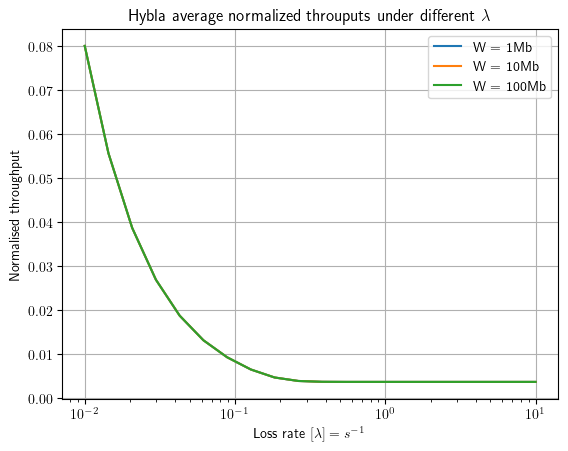

In [21]:
err_rates = np.logspace(-2,1,20)
throughputs = np.zeros([3,len(err_rates)])
for k,RTT in enumerate([0.5,0.1,0.05]):
    for i, l in enumerate(err_rates):
        wired = CCA_MarkovChain_Hybla_time(err_rate=1,beta=0.5,N=100,C = 1000000 ,RTT_real=RTT, RTT0=0.05)
        throughputs[k,i] = wired.avg_throughput()

plt.plot(err_rates,throughputs[0,:], label = "W = 1Mb")
plt.plot(err_rates,throughputs[1,:], label = "W = 10Mb")
plt.plot(err_rates,throughputs[2,:], label = "W = 100Mb")
plt.semilogx()
plt.legend()
plt.grid()
plt.title(r"Hybla average normalized throuputs under different $\lambda$")
plt.xlabel(r"Loss rate $[\lambda] = s^{-1}$")
plt.ylabel(r'Normalised throughput')
plt.show()

### Comparison
Finally, we compare both congestion control algorithms by varying parameters. Although we talk about throughput, what we really compute is the average congestion window size under 

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from ccaModels import CCA_MarkovChain_CUBIC_time, CCA_MarkovChain_Hybla_time

plt.rcParams['text.usetex'] = True

err_rates = np.logspace(-2,2,30)
throughputs_hybla_bandwidth = np.zeros([3,len(err_rates)])
throughputs_cubic_bandwidth = np.zeros([3,len(err_rates)])
throughputs_hybla_rtt = np.zeros([3,len(err_rates)])
throughputs_cubic_rtt = np.zeros([3,len(err_rates)])

for k,C in enumerate([10000,100000,1000000]):
    for i, l in enumerate(err_rates):
        wireless = CCA_MarkovChain_Hybla_time(err_rate=l,beta=0.5,alpha=1,N=100, C = C, RTT_real=0.1, RTT0=0.025)
        throughputs_hybla_bandwidth[k,i] = wireless.avg_throughput()
        wired = CCA_MarkovChain_CUBIC_time(err_rate=l,beta=0.5,alpha=1,N=100,C = C, RTT_real = 0.1)
        throughputs_cubic_bandwidth[k,i] = wired.avg_throughput()

for k,R in enumerate([0.025,0.1,0.6]):
    for i,l in enumerate(err_rates):
        wireless = CCA_MarkovChain_Hybla_time(err_rate=l,beta=0.5,alpha=1,N=100, C = 100000, RTT_real=R, RTT0=0.025)
        throughputs_hybla_rtt[k,i] = wireless.avg_throughput()
        wired = CCA_MarkovChain_CUBIC_time(err_rate=l,beta=0.5,alpha=1,N=100,C = 100000, RTT_real = R)
        throughputs_cubic_rtt[k,i] = wired.avg_throughput()

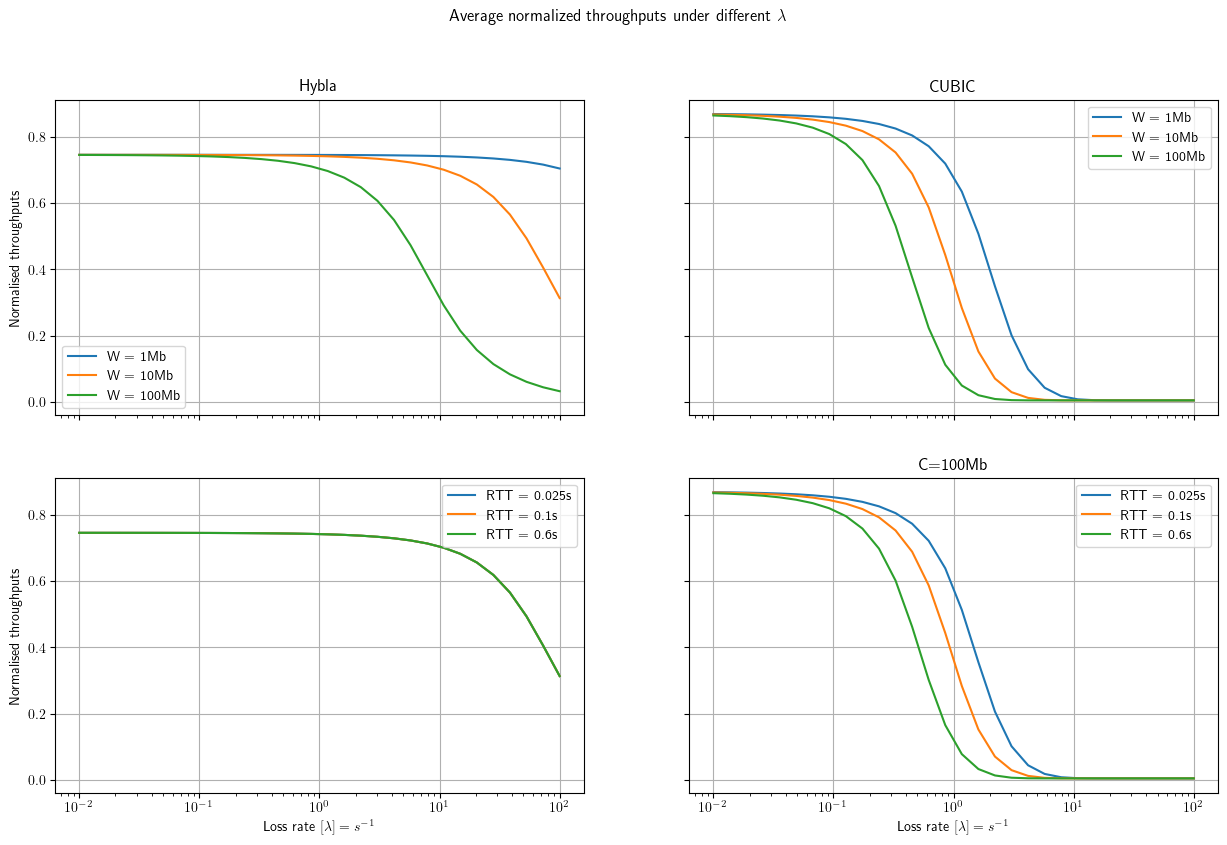

In [20]:
fig, axs = plt.subplots(2, 2,figsize=(15,9),sharex=True, sharey=True)
fig.suptitle("Average normalized throughputs under different $\lambda$")

axs[0, 0].plot(err_rates, throughputs_hybla_bandwidth[0,:],label = "W = 1Mb")
axs[0,0].plot(err_rates,throughputs_hybla_bandwidth[1,:], label = "W = 10Mb")
axs[0,0].plot(err_rates,throughputs_hybla_bandwidth[2,:], label = "W = 100Mb")
axs[0,0].semilogx()
axs[0,0].legend()
axs[0,0].grid()
axs[0,0].set_title(r"Hybla")

axs[0,1].plot(err_rates, throughputs_cubic_bandwidth[0,:],label = "W = 1Mb")
axs[0,1].plot(err_rates,throughputs_cubic_bandwidth[1,:], label = "W = 10Mb")
axs[0,1].plot(err_rates,throughputs_cubic_bandwidth[2,:], label = "W = 100Mb")
axs[0,1].semilogx()
axs[0,1].legend()
axs[0,1].grid()
axs[0,1].set_title(r"CUBIC")

axs[1,0].plot(err_rates, throughputs_hybla_rtt[0,:],label = "RTT = 0.025s")
axs[1,0].plot(err_rates,throughputs_hybla_rtt[1,:], label = "RTT = 0.1s")
axs[1,0].plot(err_rates,throughputs_hybla_rtt[2,:], label = "RTT = 0.6s")
axs[1,0].semilogx()
axs[1,0].legend()
axs[1,0].grid()

axs[1,1].plot(err_rates, throughputs_cubic_rtt[0,:],label = "RTT = 0.025s")
axs[1,1].plot(err_rates,throughputs_cubic_rtt[1,:], label = "RTT = 0.1s")
axs[1,1].plot(err_rates,throughputs_cubic_rtt[2,:], label = "RTT = 0.6s")
axs[1,1].semilogx()
axs[1,1].legend()
axs[1,1].grid()
axs[1,1].set_title(r"C=100Mb")

for ax in axs.flat:
    ax.set(xlabel=r"Loss rate $[\lambda] = s^{-1}$", ylabel=r'Normalised throughputs')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()